<a href="https://colab.research.google.com/github/sausis20/Stock-Portfolio-Nasdaq-Baltic/blob/main/modeling_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.dates as mdates

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks/Nasdaq OMX Baltic/data/'

/content/gdrive/My Drive/Colab Notebooks/Nasdaq OMX Baltic/data


In [3]:
df = pd.read_csv('combined_df.csv', index_col=0)

# Modeling Returns and Feature Selection

In the second part of the analysis I will model the returns over the six month period since the companies fundamental data was published. This will be done by creating a binary classifier to predict gainers/losers (returns above or less than or equal to zero). The model will be tested on the holdout set, although it should be noted that this will be done during the same time period, therefore it may be worthwile to test the model on different time periods in the future.

The problem could be described as follows:
-   null hypothesis - the securities fundamental data has no predictive information about the securities returns
-   alternative hypothesis - there is predictive information about securities returns in their fundamental data

In [4]:
log_returns = pd.read_csv('log_returns.csv', index_col=0)
targets = log_returns.copy()
targets.loc[targets.log_return > 0, 'classif'] = 1
targets.loc[targets.log_return <= 0, 'classif'] = 0
targets.head()

,log_return,classif
APG1L.VS,0.020726,1.0
ARC1T.TL,-0.113182,0.0
AUG1L.VS,-0.204314,0.0
BLT1T.TL,-0.392562,0.0
CPA1T.TL,-0.068295,0.0


## Feature selection

Similar to previous task, we will remove the variables that do not contain information about the fundamentals of the company are also removed, i.e. 'city', 'phone', 'fax', etc. However, this time we will leave the pricing data intact.


In [5]:
to_drop = ['zip', # Not fundamental
           'longBusinessSummary', # Not fundamental
           'city', # Not fundamental
           'phone', # Not fundamental
           'companyOfficers', # Not fundamental
           'website', # Not fundamental
           'maxAge', # Not fundamental
           'address1', # Not fundamental
           'fax', # Not fundamental
           'recommendationKey', # Not fundamental
           'numberOfAnalystOpinions', # Not fundamental
           'financialCurrency', # Not fundamental
           'exchange', # Same as country
           'shortName', # Not fundamental
           'longName', # Not fundamental
           'exchangeTimezoneName', # Not fundamental
           'exchangeTimezoneShortName', # Not fundamental
           'isEsgPopulated', # Not fundamental
           'gmtOffSetMilliseconds', # Not fundamental
           'quoteType', # Not fundamental
           'symbol', # Not fundamental
           'messageBoardId', # Not fundamental
           'uuid', # Not fundamental
           'market', # Not fundamental
           'forwardEps', # Missing too many values       
           'nextFiscalYearEnd', # Not fundamental
           'mostRecentQuarter', # Not fundamental
           'lastSplitDate', # Not fundamental
           'lastSplitFactor', # Not fundamental
           'currency', # Not fundamental
           'tradeable', # Not fundamental
           'logo_url', # Not fundamental
           'address2', # Not fundamental
           'Company', # Not fundamental
           'IND.', # Not fundamental
           'SECT.', # Not fundamental
           'Home Market', # Not fundamental
           'exDividendDate', # Not fundamental
           'fiveYearAvgDividendYield', # Missing too many values
           'grossProfits', # Duplicate of 'Gross Profit',
           'sector', # Not fundamental
           'country', # Not fundamental
           'industry', # Not fundamental
           'pegRatio', # Missing too many values
           'forwardPE', # Missing too many values
           'lastFiscalYearEnd', # Not fundamental
           'askSize', # Not fundamental
           'bidSize', # Not fundamental
           ]

In [6]:
X = df.drop(columns=to_drop)
print(df.shape, X.shape)

(30, 182) (30, 134)


In [7]:
X.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, APG1L.VS to VLP1L.VS
Data columns (total 134 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    fullTimeEmployees                             30 non-null     int64  
 1    ebitdaMargins                                 30 non-null     float64
 2    profitMargins                                 30 non-null     float64
 3    grossMargins                                  30 non-null     float64
 4    operatingCashflow                             27 non-null     float64
 5    revenueGrowth                                 29 non-null     float64
 6    operatingMargins                              30 non-null     float64
 7    ebitda                                        25 non-null     float64
 8    targetLowPrice                                7 non-null      float64
 9    freeCashflow                                  

In [8]:
# Replace NaN to 0 for all features coming from financial statements
X.iloc[:,75:] = X.iloc[:,75:].fillna(0)

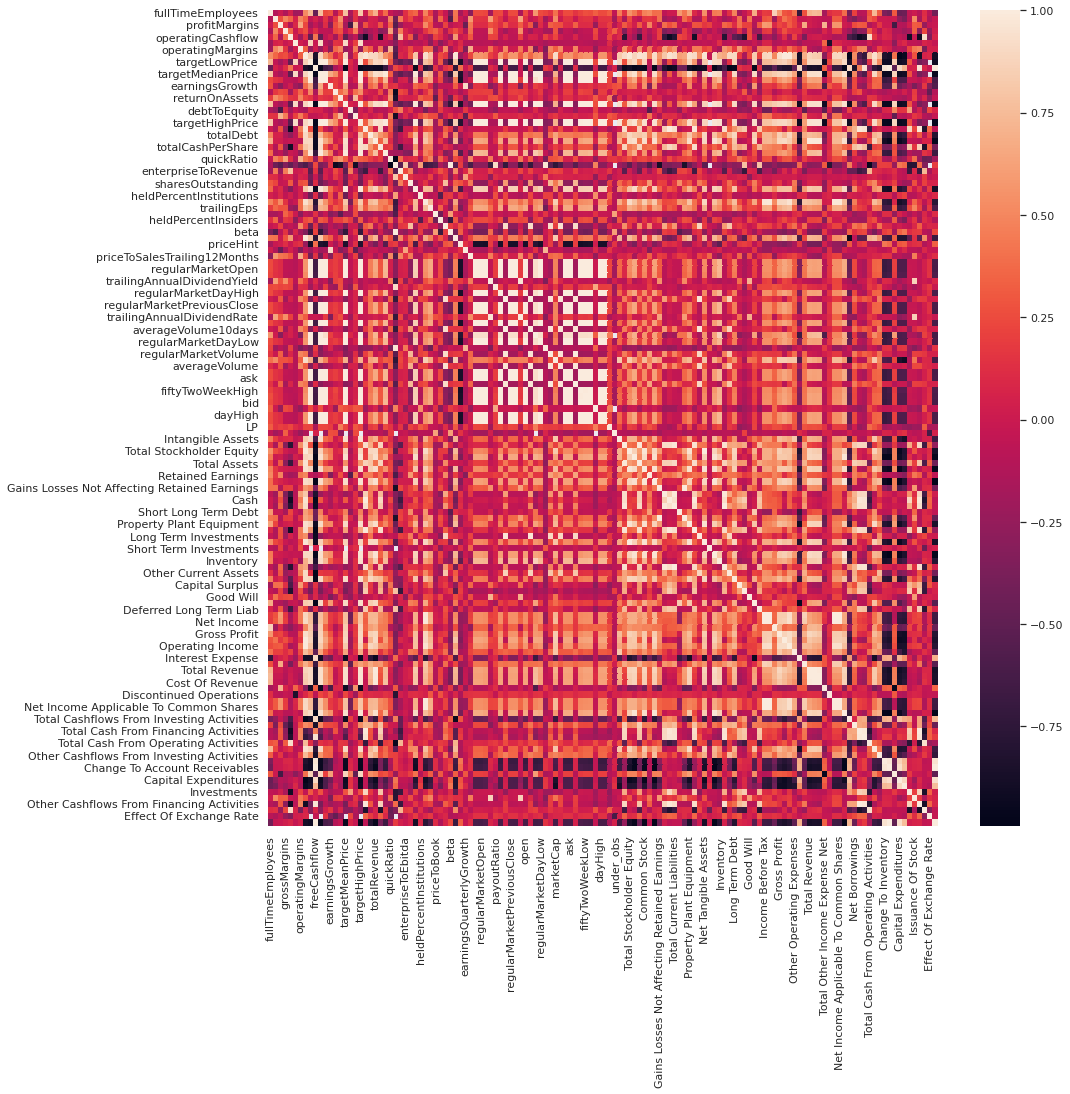

In [9]:
corr = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

In [10]:
to_drop = ['freeCashflow', 'operatingCashflow', 'Interest Expense', 'Total Cashflows From Investing Activities', 'Change To Inventory', 
            'Change To Account Receivables', 'Capital Expenditures', 'Dividends Paid', 'Total Cashflows From Investing Activities', 
            'Change To Operating Activities', 'Repurchase Of Stock', 'Total Cash From Operating Activities', 'recommendationMean', 'beta', 'priceHint'     
            ]
X = X.drop(columns=to_drop)

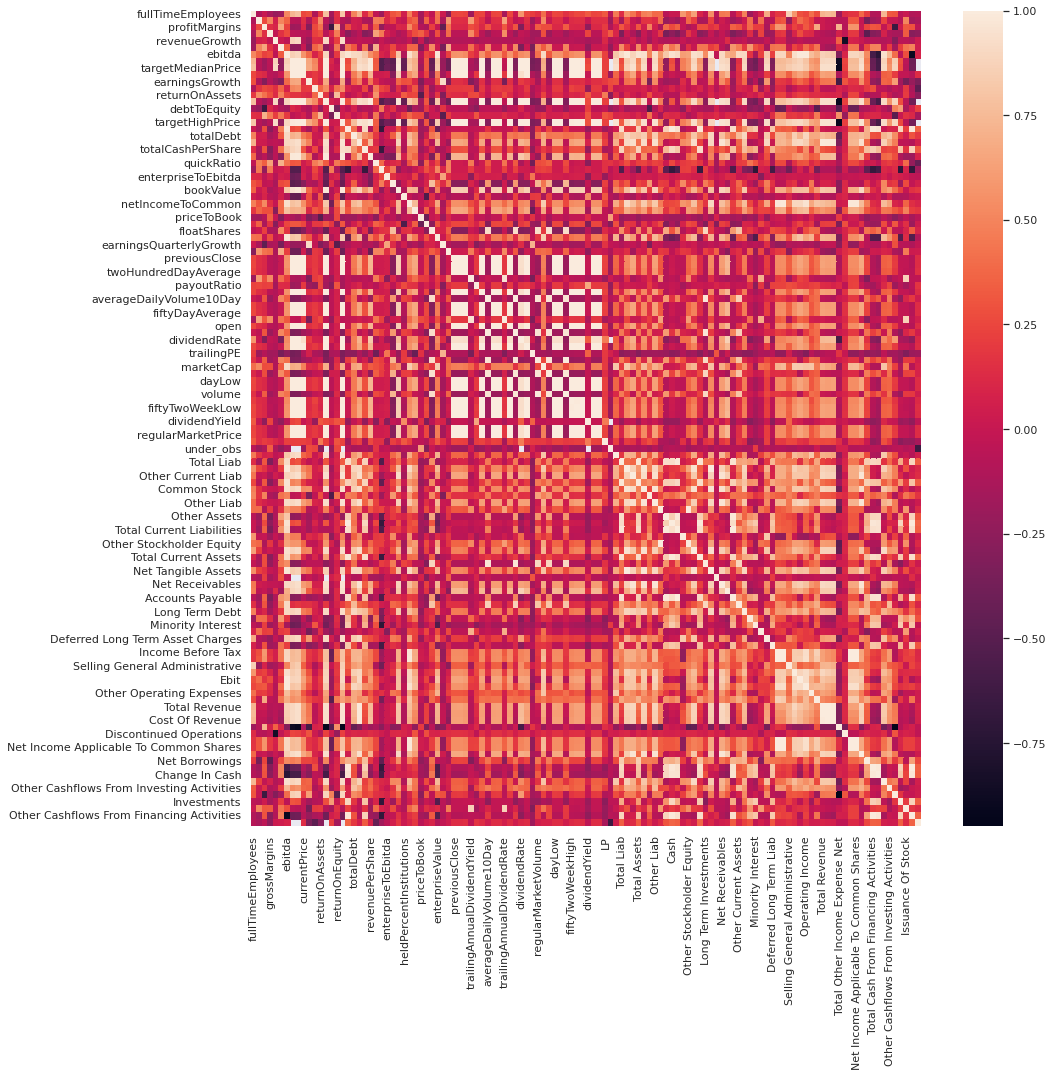

In [11]:
corr = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

This looks a lot better, and athough there is still some correlation between variables present, we have removed most of it and can move on to the imputation and modeling phases.

## Classification - Gainers/Losers

As in the previous task, we begin by comparing missing data imputation techniques and regressors.

In [12]:
y = targets.classif

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [14]:
clf = KNeighborsClassifier()

In [15]:
N_SPLITS = 3

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler



# Function to score the results on the differently imputed data
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, clf)

    # To estimate the score of each method, we will use cross-validation (CV). 
    # CV is a procedure that splits the data into smaller sets, loops through each split to train and test the model on different parts of the dataset, and then evaluates the performance by averaging the values computed in the loop.
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring='roc_auc', cv=N_SPLITS)
    return impute_scores

x_labels = []

scores = np.zeros(4)
stds = np.zeros(4)

# Replace missing values by 0
def get_impute_zero_score(X_missing, y_missing):

    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0)
    
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


scores[0], stds[0] = get_impute_zero_score(X, y)

x_labels.append("Zero imputation")


# Impute missing values with mean
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


scores[1], stds[1] = get_impute_mean(X, y)

x_labels.append("Mean Imputation")


# kNN-imputation of the missing values
# I used MinMaxScaler from scikit-learn to normalize this numeric data between 0 and 1, since KNNImputer is a distance-based algorithm 
def get_impute_knn_score(X_missing, y_missing):
    # Define scaler to set values between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_missing_scaled = X_missing.copy()
    X_missing_scaled = pd.DataFrame(scaler.fit_transform(X_missing_scaled), columns=X_missing_scaled.columns)

    # n_neighbors is the selected number of neighboring samples to use for imputation, by default set to 5
    # metric which is the distance metric for searching neighbors by default set as ‘nan-euclidean’
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors=5, metric='nan_euclidean')
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing_scaled, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


scores[2], stds[2] = get_impute_knn_score(X, y)

x_labels.append("KNN Imputation")


# Iterative imputation of the missing values
# In this case the column with missing values is the taget variable, and other features are used to train the model to predict (impute) 
# the missing values in the target variable. It does so in an iterated round-robin fashion: this is done for each feature, and then is 
# repeated for max_iter imputation rounds. The results of the final imputation round are returned
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(missing_values=np.nan,
                               add_indicator=True,
                               random_state=0,
                               n_nearest_features=3,
                               max_iter=3,
                               sample_posterior=True)
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


scores[3], stds[3] = get_impute_iterative(X, y)

x_labels.append("Iterative Imputation")

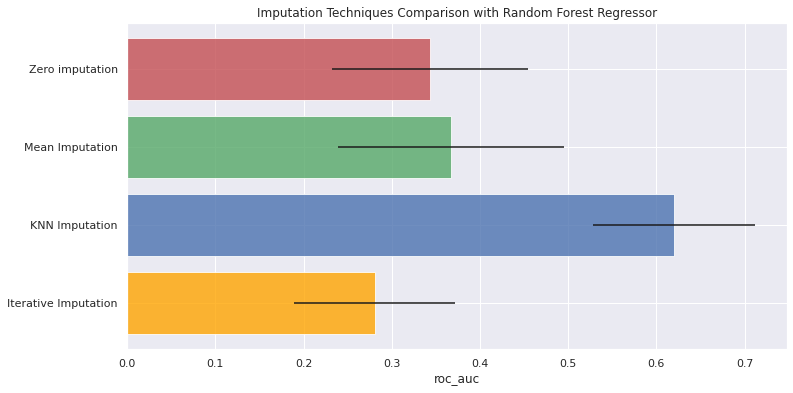

In [30]:
# Plot the results of imputation comparisons

n_bars = len(scores)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange"]

plt.figure(figsize=(26, 6))
ax1 = plt.subplot(1, 2, 1)
for j in xval:
          ax1.barh(j, 
          scores[j], 
          xerr=stds[j],
          color=colors[j],
          alpha=0.8,
          align='center')

ax1.set_title('Imputation Techniques Comparison with Random Forest Regressor')
#ax1.set_xlim(left=np.min(scores) * 0.9, right=np.max(scores) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('roc_auc')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

plt.show()

After evaluating different classification regressors - LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier (not shown here) and KNeighborsClassifier, the KNeighborsClassifier, combined with KNN imputation technique proved to have the best performance in terms of roc_auc score of around 0.62. 

The AUC value, which in itself ranges between 0 and 1, represents the probability that the prediction is accurate, i.e. a model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

## Modelling the data

In [17]:
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.neighbors import KNeighborsClassifier

# In this part of the analysis I compared different classifires (listed above), from which RandomForestClassifier 
# provided the best performance

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create estimator pipeline to be optimized
imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors=2, metric='nan_euclidean')

clf = RandomForestClassifier(random_state=0)
steps = [#('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

# Make parameter grid to search
param_grid = {'clf__n_estimators': [10, 15, 25],
              #'clf__criterion': ['gini', 'entropy', 'log_loss']
              }

# Make grid search and fit
grid_search = GridSearchCV(estimator, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=3,
                           verbose=1)
grid_fit = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [19]:
# Best CV roc_auc score:
grid_fit.best_score_

0.8333333333333334

In [20]:
print('Best CV roc_auc score:', grid_fit.best_score_)
grid_fit.best_params_

Best CV roc_auc score: 0.8333333333333334


{'clf__n_estimators': 15}

In [21]:
# The optimal value for n_estimators is 15, as opposed to the default value of 100 
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit.best_estimator_.predict_proba(X_test)
probas[:]

array([[0.66666667, 0.33333333],
       [0.46666667, 0.53333333],
       [0.66666667, 0.33333333],
       [0.86666667, 0.13333333],
       [0.66666667, 0.33333333],
       [0.46666667, 0.53333333],
       [0.46666667, 0.53333333],
       [0.8       , 0.2       ],
       [0.73333333, 0.26666667]])

Here we have the predictions by the model - the first number being the probability that the output will be 0 and the second being the probability of output being 1.

Let's visualize the probabilities of securities being assigned to gainers = 1.

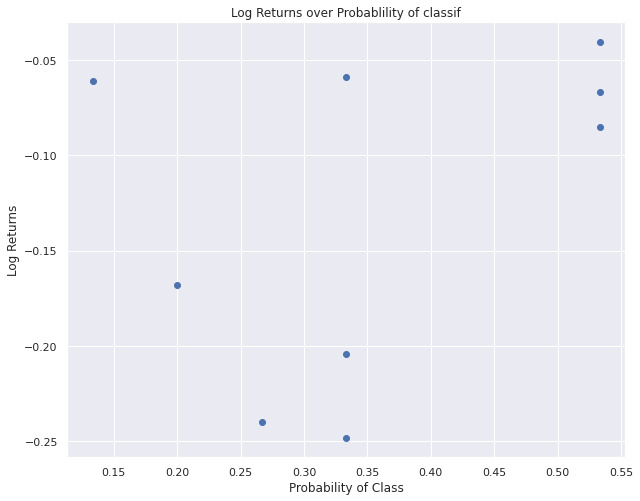

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(probas[:, 1], targets.log_return[X_test.index])
plt.title('Log Returns over Probablility of classif')
plt.xlabel('Probability of Class')
plt.ylabel('Log Returns');

We can see that all of the securities in the test sample had negative returns, and the model correctly assigned most of them to the 0 (losers) category (we can see that from the x axis, which shows the probability of being in the 1 (gainers) category).

Next, let's fit a Linear Regreesion to see if the model is effective.

In [23]:
test_df = pd.DataFrame(list(zip(probas[:,1], log_returns.log_return[X_test.index])), 
                       index=X_test.index)
test_df.columns = ['probs', 'log_returns']

coefficient of determination: 0.1435113848474423


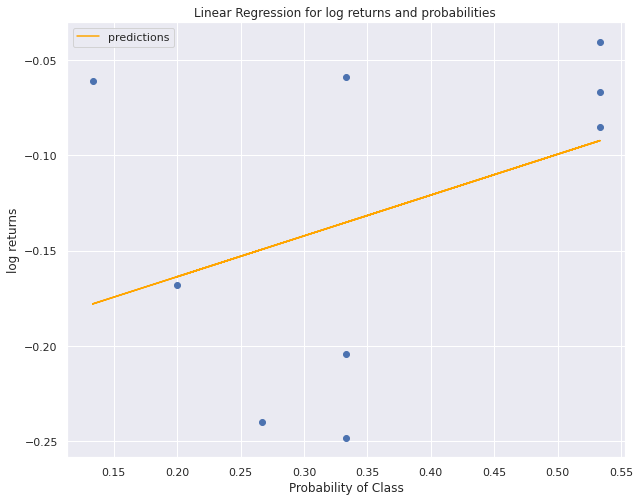

In [35]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

x = np.array(test_df['probs']).reshape((-1, 1))
y1 = np.array(test_df['log_returns'])

model = LinearRegression().fit(x, y1)

r_sq = model.score(x, y1)
print(f"coefficient of determination: {r_sq}")

y_pred = model.predict(x)

plt.figure(figsize=(10, 8))
plt.scatter(test_df['probs'], test_df['log_returns'])
plt.xlabel('Probability of Class')
plt.ylabel('log returns')
plt.title('Linear Regression for log returns and probabilities ')

plt.plot(test_df['probs'], y_pred, color='orange', label='predictions')
plt.legend()
plt.show()

We can see that the regression line has the slope we expected - probability of being assigned to the gainers category (1) increases as the log returns increase, so this is encouraging. However, the R-squared for this simple linear regression of the log returns using the predicted probabilities is very low at .144. Let's also check the p-value to see if the model has statistical significance.

In [ ]:
import statsmodels.api as sm

X2 = sm.add_constant(x)
est = sm.OLS(y1, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.173
Date:                Wed, 28 Dec 2022   Prob (F-statistic):              0.315
Time:                        07:13:56   Log-Likelihood:                 10.731
No. Observations:                   9   AIC:                            -17.46
Df Residuals:                       7   BIC:                            -17.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2065      0.076     -2.734      0.0

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We can see that the p-value is at 0.315, or in other words, there is 31.5% chance that the test results occured under the null hypothesis i.e. by pure chance. 

At this point we have to make the conclusion that the model is not effective in predicting the securities returns from the fundamental data. Although the regression line seemed promising at first, the determination coefficient (R-squared) and p-test indicate that the model is not statistically significant and we can't reject the null hypothesis. 

One of the main reasons for this result that comes to mind is the small sample size of 30 observations, however hat is the number of securities in the Baltic Main List.

# Portfolio construction

Although the model was found to not have statistical significance, we can still construct portfolio based on its predictions, which could serve as a template if the study is performed at some point in the future with a different dataset.

One potential application of this model could be demonstrated by constructing a long/short equity portfolio using the model’s predictions of over/under performers. The benefit of the long/short equity strategy is that the investor is hedged against the market by taking an equal amount of long and short positions. This way, the portfolio is not affected by overall upward or downward movement of the market, and instead is only affected by how well the investor has predicted the relative performance of securities within it. Although our model proved to be not statistically significant - mainly because of the small sample size and relatively short time period studied - the model is still correctly identifying over and under performers with an accuracy of 83,3%. Combining this predictive power with a long/short equity strategy this can lead to a consistently profitable trading strategy by both diversifying the risk of the portfolio by taking many positions and also hedging against the market. If the market moves up, the investor will gain from their long positions while losing on their short positions, and conversely if the market moves down, they will gain on their short positions while losing on their long positions. By having predicted with better than random accuracy which securities were set to over or underperform the market, the gains from the winning side of the portfolio should average out to be bigger than the losses from the losing side, no matter which way the market moves.

We can simulate how such a portfolio would have performed using the securities of the test set by using the class predictions for each security. For securities that the model predicts we should short, we will flip the sign of their respective log returns to indicate that we will profit from the drop in these stocks' prices. Finally, we will average all of these adjusted returns together. This would be the equivalent of the investor making equal dollar investments into each security in the test set, going short in any stock predicted by the model to underperform, and going long in any stock predicted to overperform.

In [ ]:
preds = grid_fit.best_estimator_.predict(X_test).astype('int')
preds

array([0, 1, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
# Create pandas series with the models predictions and assign ticker index
preds_series = pd.Series(preds, index=y_test.index)
# Combine the log returns and predictions into a dataframe
returns_preds_df = pd.concat([log_returns.log_return[y_test.index], preds_series], axis=1)
# Name our dataframe columns
returns_preds_df.columns = ['log_return', 'pred']

# Create a new column which can be multiplied with log_return to reverse signs for shorted stocks
returns_preds_df['return_multiplier'] = returns_preds_df['pred'].map(lambda x: -1 if x == 0 else 1)
returns_preds_df.head()

,log_return,pred,return_multiplier
AUG1L.VS,-0.204314,0,-1
TVE1T.TL,-0.040814,1,1
KNF1L.VS,-0.247942,0,-1
HMX1R.RG,-0.060977,0,-1
TKM1T.TL,-0.059020,0,-1


In [ ]:
log_close = pd.read_csv('log_close.csv', index_col=0)
log_returns_full = log_close.diff()
log_returns_full.head()

,APG1L.VS,ARC1T.TL,AUG1L.VS,BLT1T.TL,CPA1T.TL,DGR1R.RG,EEG1T.TL,EGR1T.TL,GRG1L.VS,HAE1T.TL,...,PZV1L.VS,RSU1L.VS,SAB1L.VS,SFG1T.TL,TAL1T.TL,TEL1L.VS,TKM1T.TL,TSM1T.TL,TVE1T.TL,VLP1L.VS
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-24,0.013004,0.009901,-0.009806,0.004320,-0.005721,0.004205,0.000000,-0.007643,-0.011948,0.000000,...,-0.011342,0.000000,-0.006493,-0.010411,-0.007299,0.0,0.003945,-0.003904,0.001440,0.000000
2022-05-25,-0.002587,-0.004938,0.003893,-0.008658,-0.012371,-0.014085,-0.017094,0.007136,0.011948,-0.004751,...,0.003795,-0.019803,-0.014766,0.032942,-0.011050,0.0,-0.007905,-0.002611,0.001438,0.002350
2022-05-27,0.007742,0.002472,-0.002252,0.000000,0.018907,0.008475,0.005731,0.032970,-0.016767,0.000000,...,-0.003795,0.000000,0.004946,0.025125,-0.001854,0.0,-0.001986,0.000000,0.000000,-0.004706
2022-05-30,0.007682,0.017136,-0.000205,-0.008734,0.008918,0.000000,-0.014389,0.007344,-0.002418,0.000000,...,-0.003810,0.000000,0.001643,0.012147,0.009234,0.0,0.011858,0.000000,0.000000,-0.007101


We can get a better understanding of how the securities in the test compare to the overall market by visualizing their performance.

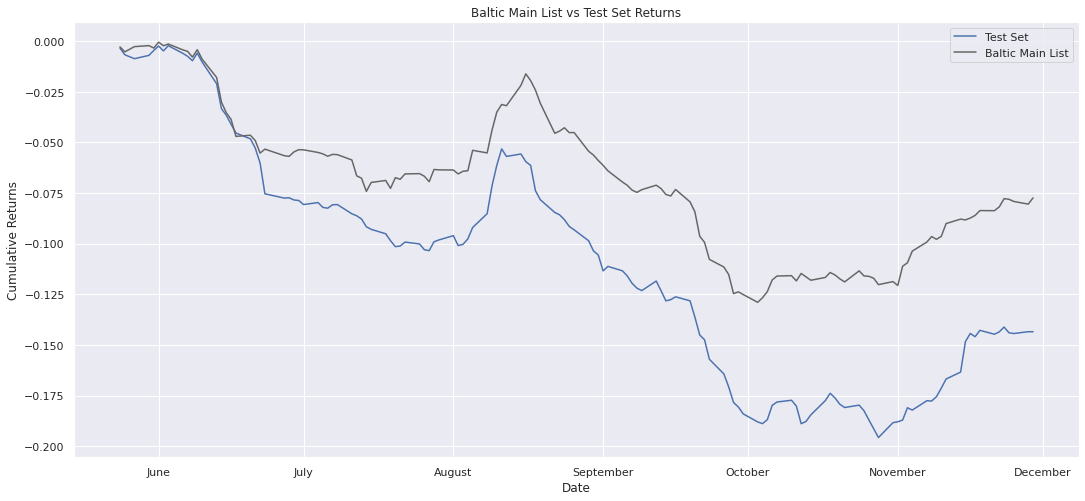

In [ ]:
# Plotting the entire Baltic Main List vs. the test set
log_returns_full.index = pd.to_datetime(log_returns_full.index)

plt.figure()
plt.plot(log_returns_full[y_test.index].mean(axis=1).cumsum(), label='Test Set')
plt.plot(log_returns_full.mean(axis=1).cumsum(), c='#666666', label='Baltic Main List')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.title('Baltic Main List vs Test Set Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend();

We can see that the securities in the test set have noticably underperformed the overal market, however the overall shape of the returns is almost exactly the same. We can also see that during the study period, the overall market was in a correction / bear market. 

At this point we can use the predictions of under and over performers given by the model to split the securities in the test set into long and short positions. The portfolio will go long in all companies predicted to outperform, and short in the companies that were predicted to underperform. 

To construct this portfolio, we will split the securities into the long side and short side, reverse the sign of the short side, and then recombine the two. Finally, we will look at a plot comparing the returns of a buy & hold strategy of the test set vs the long/short portfolio we have made.

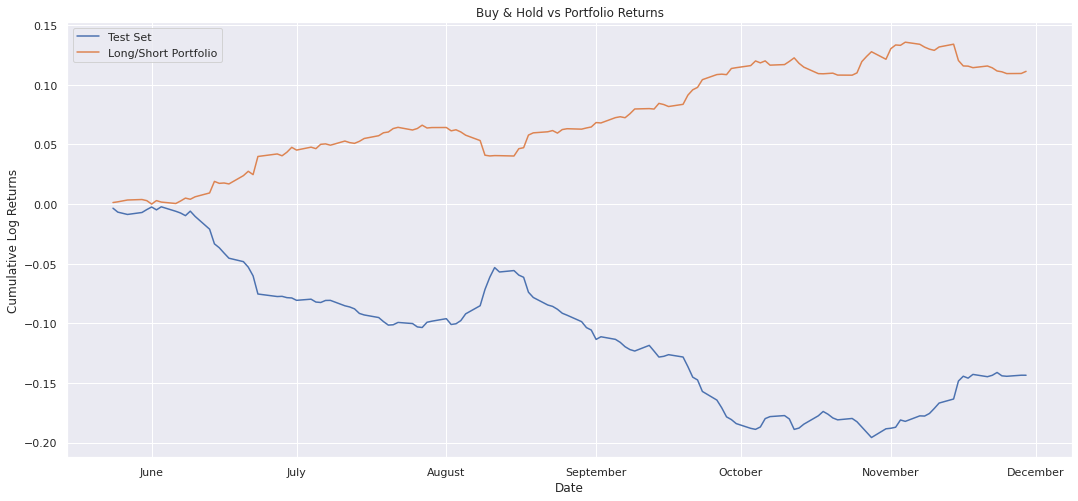

In [ ]:
# Separate the long and short positions of our portfolio
long_tickers = returns_preds_df[returns_preds_df['pred'] == 1].index
short_tickers = returns_preds_df[returns_preds_df['pred'] == 0].index
long_positions = log_returns_full[long_tickers]
short_positions = log_returns_full[short_tickers]

# Combine long and short positions to make portfolio, reversing sign of short positions
full_portfolio_returns = pd.concat([long_positions, -short_positions], axis=1)

# Plot Buy & Hold Strategy vs Portfolio
plt.plot(log_returns_full[y_test.index].mean(axis=1).cumsum(), label='Test Set')
plt.plot(full_portfolio_returns.mean(axis=1).cumsum(), label='Long/Short Portfolio')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns')
plt.title('Buy & Hold vs Portfolio Returns')
plt.legend();

We can see that the Long/Short portfolio significantly over performed the test set portfolio. This can be explained by the fact that because the overal market was declining over the study period, a strategy that is able to short stocks will perform significantly better than simple Buy-and-hold strategy. Next, let's take a look at the returns of the long side of the portfolio and the short side of the portfolio separately.

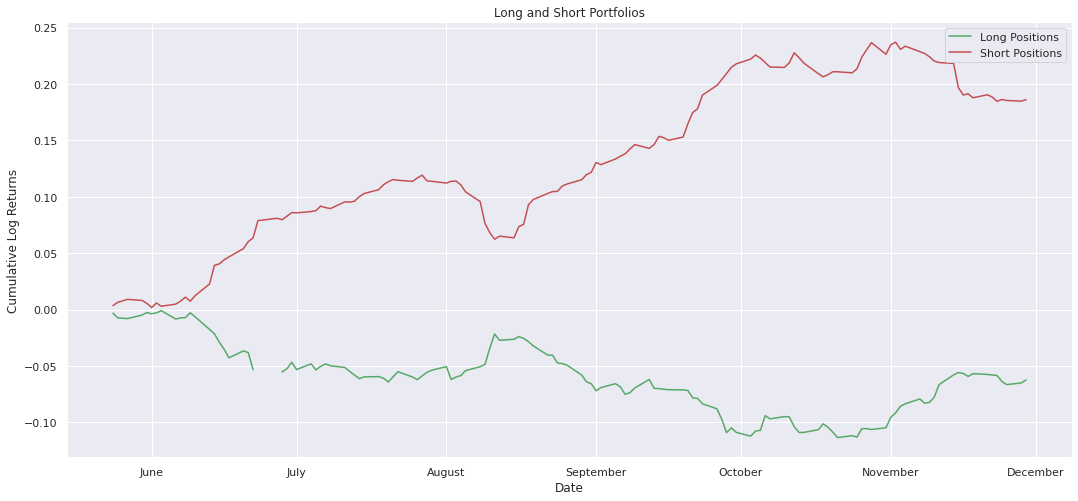

In [ ]:
# Looking at the long side and short side of our portfolio separately
plt.plot(long_positions.mean(axis=1).cumsum(), color='g', label='Long Positions')
plt.plot(-short_positions.mean(axis=1).cumsum(), color='r', label='Short Positions')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.title('Long and Short Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns')
plt.legend();

Again, we see that the Short side was performing significantly better than the Long side. 

Notice how both lines start at 0, but the red line finishes at around 0.18, while the green line finishes at around -0.06. The fact that the red line makes more profit than the green line loses is exactly the goal of the strategy! By going long on the securities that the model predicted will over perform, and going short on the securities that the model predicted will under perform, the aggregate result of the portfolio would be positive.

At this point a question comes to mind - why not just take the short positions, and skip the long positions? The answer to this question requires knowing the general direction of the market. Since during the study period the market was in a downturn, the short side was performing better. However, if the market were to enter a bull market, we would expect the long side to become more profitable. Let's simulate how the portfolio would have behaved in the opposite (bull) market scenario.

First, compare how the simulated bull market looks agains the actual market.

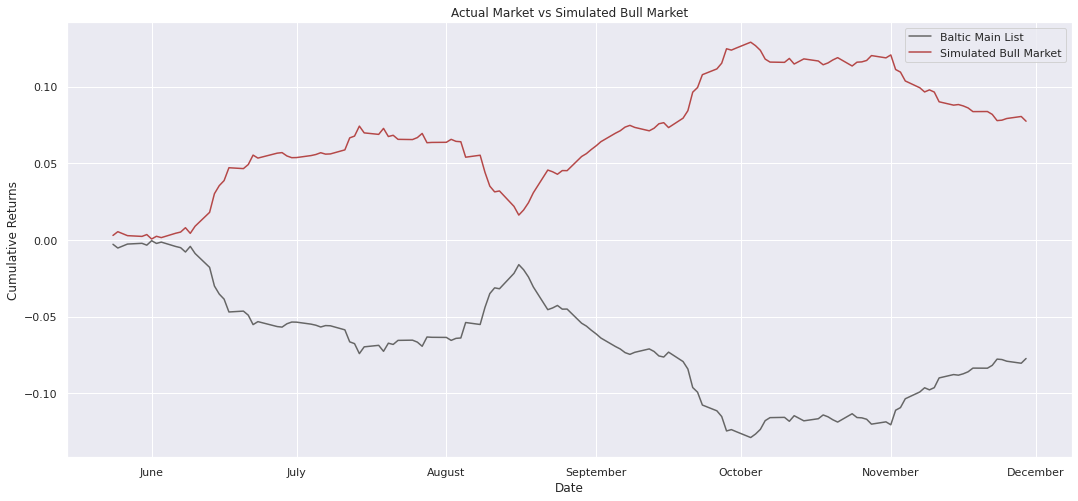

In [ ]:
# Make copy of the dataframe to simulate bull market
bull_market = log_returns_full.copy()

# Subtract twice the daily average of log returns from each return that day
for idx in bull_market.index:
    bull_market.loc[idx] = bull_market.loc[idx] - 2 * bull_market.loc[idx].mean()

# Plot the results
plt.plot(log_returns_full.mean(axis=1).cumsum(), c='#666666', label='Baltic Main List')
plt.plot(bull_market.mean(axis=1).cumsum(), c='#b54848', label='Simulated Bull Market')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.title('Actual Market vs Simulated Bull Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend();

We can see that the simulated market has mirrored the cumulative returns of actual market. Let’s see how the portfolio that we constructed from the model would have performed vs the simulated bull market conditions.

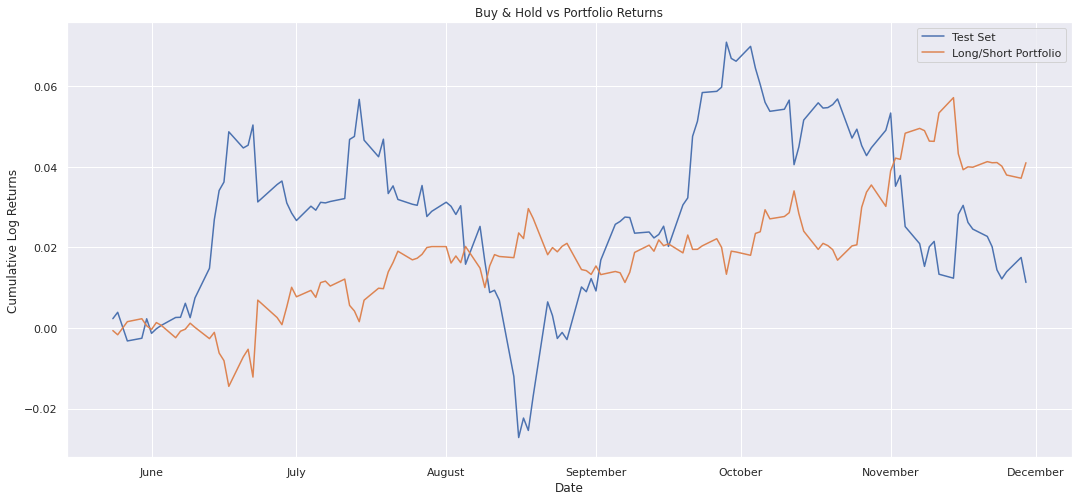

In [ ]:
# Separate the long and short positions of our portfolio
long_positions_bull = bull_market[long_tickers]
short_positions_bull = bull_market[short_tickers]

# Combine long and short positions to make portfolio, reversing sign of short positions
bull_portfolio_returns = pd.concat([long_positions_bull, -short_positions_bull], axis=1)

# Plot Buy & Hold Strategy vs Portfolio
plt.plot(bull_market[y_test.index].mean(axis=1).cumsum(), label='Test Set')
plt.plot(bull_portfolio_returns.mean(axis=1).cumsum(), label='Long/Short Portfolio')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns')
plt.title('Buy & Hold vs Portfolio Returns')
plt.legend();

At this point we can clearly see the advantages of Long/Short portfolio strategy - during the favorable market conditions the portfolio is still overperforming the Buy-and-hold portfolio. On top of that, the volatility of the portfolio is much lower, compared to the big swings in the traditional portfolio.

# Conclusions

This study was focused on modeling intrinsic asset prices and modeling the return on the securities in the Nasdaq OMX Baltic Main List. We began by scraping the relevant tickers from the Nasdaq websitem, which yielded a total of 34 tickers. Next, we obtained the fundamental data for these companies, such as Cash Flow, Net Income, Long Term Investments, Cash, etc. using the yfinance API, upon which 4 tickers with no data were removed and we were left with 30 tickers. 

The data obtained was then used in a number of investigations. First, we attempted to create an asset pricing model which could aid in a value investing strategy over a 6 month period by regressing the prices of the stocks on the day when the fundamental company data was published and attempting to use the residuals as margins of safety. Then, we moved onto modeling the returns. We first created a new category to classify the securities that had positive returns (gainers) and negative returns (losers), and then trained the model to predict this category. The trained model returned an accuracy score of 83.3%, however, the results proved to be not statistically significant with R-squared of around 0.14. Once a model was trained, a simulated portfolio was constructed in a long/short equity strategy to show how the model’s predicted stock picks would have performed. The simulation showed that the model was profitable when the actual market was in a downturn, mainly because of the ability to short stocks predicted by the model to have negative returns. Lastly, I simulated a bull market to see how the model would perform in the opposite environment than it was trained on. The results showed that the model was again profitable (although not as much as during the downturn) and had a much lower volatility compared to a traditional Buy-and-hold strategy.

The study has shown some really interesting results and gave me a chance to investigate a, interesting dataset, but an additional study on this subject would be appropriate. Here are a few things which could be improved in future work: 
-   The companies in the Nasdaq Baltic Main List has data for just 30 securities, however the total number of features were 105 (if we exclude features related to pricing information) and 120 features (if we include them). Generally, we would want to have more observations than features, so the model could be improved by making it more parsimonious (checking and removing features that add little or no explanatory power to the model).
-   Additionally, it is relatively difficult to get a working model with such a few observations, therefore it could be worthwile to repurpose this study to include more observations, for example by analysing the whole Central-Eastern European stock market or including other markets that have comparable charachteristics as the Baltic stock market.
